In [58]:
# 必要なモジュールのインポート
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
# score指標
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score
# H.O.
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import matplotlib.pyplot as plt
%matplotlib inline
# warning非表示
import warnings
warnings.simplefilter('ignore')

In [59]:
# make pipelines
pipelines={
    'knn': Pipeline([('scl', StandardScaler())
                                , ('est', KNeighborsClassifier())]),
    
    'logistic': Pipeline([('scl', StandardScaler())
                                     , ('est', LogisticRegression(random_state=1))]), 
    
    'rsvc': Pipeline([('scl', StandardScaler())
                                 , ('est', SVC(C=1.0, kernel='rbf', class_weight='balanced', probability=True, random_state=1))]),
    
    'tree': Pipeline([('est', DecisionTreeClassifier(random_state=1))]),
    
    'rf': Pipeline([('est', RandomForestClassifier(random_state=1))]),
    
    'gb': Pipeline([('est', GradientBoostingClassifier(random_state=1))])
}

In [60]:
# make pipelines for PCA
pipelines_pca={
    'knn': Pipeline([('scl', StandardScaler())
                                 , ('pca', PCA(random_state=1))
                                , ('est', KNeighborsClassifier())]),
    
    'logistic': Pipeline([('scl', StandardScaler())
                                      , ('pca', PCA(random_state=1))
                                     , ('est', LogisticRegression(random_state=1))]), 
    
    'rsvc': Pipeline([('scl', StandardScaler())
                                  , ('pca', PCA(random_state=1))
                                 , ('est', SVC(C=1.0, kernel='rbf', class_weight='balanced', probability=True, random_state=1))]),
    
    'tree': Pipeline([('pca', PCA(random_state=1))
                              , ('est', DecisionTreeClassifier(random_state=1))]),
    
    'rf': Pipeline([('pca', PCA(random_state=1))
                            , ('est', RandomForestClassifier(random_state=1))]),
    
    'gb': Pipeline([('pca', PCA(random_state=1))
                            , ('est', GradientBoostingClassifier(random_state=1))])
}

In [61]:
class MyAML:
    
    # constructor
    def __init__(self, model_path, scoring_path, onehot_columns):
        """
        @param model_path: モデリングするためのデータパス
                           e.g.) 'data/model_data.csv'
                           
        @param scoring_path: 検証するデータのパス(目的変数の列は入っていないことを想定)
                             e.g.) 'data/scoring_data.csv'
                             
        @param onehot_columns: これらの列をonehot-encodingする。
                                  Noneならば、object型の列をonehot-encodingする。
                                  e.g.) ['Sex', 'Pclass', 'Embarked', ...] (see 'https://www.kaggle.com/c/titanic/data')
        """
        self.model_path = model_path
        self.scoring_path = scoring_path
        self.ohe_columns = onehot_columns
        
        self._load()
    
    
    def _load(self):
        """
        モデルデータとスコアリングデータをロードするための関数
        """
        # onehot_columnsで指定された列をobject型にする
        if self.ohe_columns is not None:
            my_dtype = {}
            for col in self.ohe_columns:
                my_dtype[col] = object
        
            # load model data
            self.model_data = pd.read_csv(self.model_path,
                                                          header = 0, 
                                                          dtype = my_dtype)

            # load scoring data
            self.scoring_data = pd.read_csv(self.scoring_path,
                                                            header = 0, 
                                                            dtype = my_dtype)
        else:
            # load model data
            self.model_data = pd.read_csv(self.model_path, header = 0)
            # load scoring data
            self.scoring_data = pd.read_csv(self.scoring_path, header = 0)
            
            
    def _one_hot_encoding(self, X: pd.DataFrame) -> pd.DataFrame:
        """
        onehotエンコーディング
        @param X: onehotエンコーディングされる前のデータ
        @return X_ohe: onehotエンコーディングされた後のデータ
        """
        # extend the columns
        pd.options.display.max_columns = 50
        
        # one_hot_encoding
        if self.ohe_columns is None:  # obejct型またはcategory型の列のみone_hot_encoding
            X_ohe = pd.get_dummies(X,
                                                   dummy_na=True,  # NULLもダミー変数化
                                                   drop_first=True)  # 最初のカテゴリーを除外
        
        else:  # self.ohe_columnsで指定された列のみone_hot_encoding
            X_ohe = pd.get_dummies(X,
                                                   dummy_na=True,  # NULLもダミー変数化
                                                   drop_first=True,  # 最初のカテゴリーを除外
                                                   columns=self.ohe_columns)
        return X_ohe
    
    
    def _impute_null(self, impute_null_strategy):
        """
        欠損値をimpute_null_strategyで補完する
        impute_null_strategyの種類
        mean...平均値で補完
        median...中央値で補完
        most_frequent...最頻値で補完
        """
        self.imp = SimpleImputer(strategy=impute_null_strategy)
        self.X_model_columns = self.X_model.columns.values
        self.X_model = pd.DataFrame(self.imp.fit_transform(self.X_model),
                                                     columns=self.X_model_columns)
        
    
    def _feature_selection(self, estimator=RandomForestClassifier(n_estimators=100, random_state=0), cv=5):
        """
        特徴量選択
        @param estimator: 特徴量選択を実施するための学習器
        """
        self.selector = RFECV(estimator=estimator, step=.05, cv=cv)
        self.X_model = pd.DataFrame(self.selector.fit_transform(self.X_model, self.y_model),
                                                     columns=self.X_model_columns[self.selector.support_])
        self.selected_columns = self.X_model_columns[self.selector.support_]
        
    
    def _same_columns(self):
        """
        モデルデータのカラム名とスコアリングデータのカラム名を同じにする
        - 1. スコアリングデータにあって、モデルデータにないカラム -> 予測する際にはいらないのでドロップ
        - 2. モデルデータにあって、スコアリングデータにないカラム -> その値は0で補完
        """
        model_cols = pd.DataFrame(None,
                                                 columns=self.X_model_columns,
                                                 dtype=float)
        X_new_s2 = pd.concat([model_cols, self.X_score])

        set_Xm = set(self.X_model_columns)  # モデルデータのカラム名
        set_Xs = set(self.X_score.columns.values)  # スコアリングデータのカラム名
        X_new_s3 = X_new_s2.drop(list(set_Xs - set_Xm), axis=1)  # 1. の場合
        X_new_s3.loc[:, list(set_Xm - set_Xs)] = X_new_s3.loc[:, list(set_Xm - set_Xs)].fillna(0, axis=1)  # 2. の場合
        self.X_score = X_new_s3.reindex(self.X_model_columns, axis=1)
        
        
    def drop_cols(self, drop_cols):
        """
        指定したカラムを削除
        @param drop_cols: 削除したいカラムのリスト  e.g.) ['Name', 'Ticket', 'Cabin']
        """
        self.model_data = self.model_data.drop(drop_cols, axis=1)
        self.scoring_data = self.scoring_data.drop(drop_cols, axis=1)
        
    
    def preprocessing(self, target_col, index_col, impute_null_strategy='mean', feature_selection=True, feature_selection_cv=5):
        """
        前処理を行うための関数
        @param target_col: 目的変数のカラム名  e.g.)  'Survived'
        @param index_col: インデックスとなるカラム名  e.g.)  'index'
        @param impute_null_strategy: 欠損値を「何」で補完するか  e.g.)  'mean'
        @param feature_selection: 特徴量選択をするかどうか
        @param feature_selection_cv: 特徴量選択の際の交差検証数
        """
        # ========================
        # preprocess model data
        # ========================
        
        self.X_model = self.model_data.drop(target_col, axis=1)
        self.y_model = self.model_data.loc[:, [target_col]]
        
        # one-hot encoding
        self.X_model = self._one_hot_encoding(self.X_model)
        
        # impute NULL with means
        self._impute_null(impute_null_strategy)
        
        #feature selection
        if feature_selection:
            self._feature_selection()
        
        # ========================
        # preprocess scoring data
        # ========================
        
        self.id_score = self.scoring_data.loc[:, [index_col]]
        self.X_score = self.scoring_data.drop(index_col, axis=1)
        
        # one-hot encoding
        self.X_score = self._one_hot_encoding(self.X_score)
        
        # モデルデータのカラム名とスコアリングデータのカラム名を同じにする
        self._same_columns()

        #inplace NULL with means
        self.X_score = pd.DataFrame(self.imp.transform(self.X_score),
                                                    columns=self.X_model_columns)

        #select feature
        if feature_selection:
            self.X_score = self.X_score.loc[:, self.selected_columns]
    
    
    def holdout_method(self, pipelines=pipelines_pca, scoring='acc'):
        """
        ホールドアウト法によりモデルの精度を確認する
        @param piplines: パイプライン(試すモデルの辞書)
        @param scoring: 評価指標
                acc: 正解率
                auc: ROC曲線の面積
        """
        X_train, X_test, y_train, y_test = train_test_split(self.X_model,
                                                                               self.y_model,
                                                                               test_size=.2,
                                                                               random_state=1)
        y_train=np.reshape(y_train,(-1))
        y_test=np.reshape(y_test,(-1))

        scores={}
        for pipe_name, pipeline in pipelines.items():
            pipeline.fit(X_train, y_train)
            joblib.dump(pipeline, './model/'+ pipe_name + '.pkl')
            if scoring == 'acc':
                scoring_method = accuracy_score
            elif scoring == 'auc':
                scoring_method = roc_auc_score
            scores[(pipe_name, 'train')] = scoring_method(y_train, pipeline.predict(X_train))
            scores[(pipe_name, 'test')] = scoring_method(y_test, pipeline.predict(X_test))
        display(pd.Series(scores).unstack())
    
    
    def closs_validation(self, pipelines=pipelines_pca, scoring='roc_auc', cv=5):
        """
        @param piplines: パイプライン(試すモデルの辞書)
        @param scoring: 評価指標
                see 'https://scikit-learn.org/stable/modules/model_evaluation.html'
                例
                ‘accuracy’: metrics.accuracy_score
                ‘average_precision’: metrics.average_precision_score
                ‘f1’: metrics.f1_score for binary targets
                ‘f1_micro’: metrics.f1_score micro-averaged
                ‘f1_macro’: metrics.f1_score macro-averaged
                ‘f1_weighted’: metrics.f1_score weighted average
                ‘f1_samples’: metrics.f1_score by multilabel sample
                ‘neg_log_loss’: metrics.log_loss requires predict_proba support
                ‘precision’: etc. metrics.precision_score suffixes apply as with ‘f1’
                ‘recall’: etc. metrics.recall_score suffixes apply as with ‘f1’
                ‘roc_auc’: metrics.roc_auc_score
        @param cv: 検証回数
        """
        scores = {}
        for pipe_name, pipeline in pipelines.items():
            results = cross_val_score(pipeline,
                                                   self.X_model,
                                                   self.y_model,
                                                   scoring=scoring,
                                                   cv=cv)
            scores[(pipe_name, 'auc_avg_score')] = np.average(results)
            scores[(pipe_name, 'auc_std')] = np.std(results)
            
        display(pd.Series(scores).unstack())
    
    
    def scoring(self, model_path, scored_data_path, categorize=True):
        """
        スコアリングするための関数
        @param model_path: モデルのパス
        @param scored_data_path: スコアリングされたデータのパス
        @param categorize: Trueならばクラス分類、Falseならば確率で表現
        """
        model = joblib.load(model_path)
        if categorize:
            score = pd.DataFrame(model.predict(self.X_score), columns=['pred_score'])
        else:
            score = pd.DataFrame(model.predict_proba(self.X_score)[:,1], columns=['pred_score'])
        self.id_score.join(score).to_csv(scored_data_path, index=False)
    
    
    def roc_curves(self, pipelines=pipelines_pca):
        """
        ROC曲線を描くための関数
        @param piplines: パイプライン(試すモデルの辞書)
        """
        X_train, X_test, y_train, y_test = train_test_split(self.X_model,
                                                                               self.y_model,
                                                                               test_size=.2,
                                                                               random_state=1)
        y_train=np.reshape(y_train,(-1))
        y_test=np.reshape(y_test,(-1))
        
        plt.figure(figsize=(14,9))
        auc_scores={}
        for pipe_name, pipeline in pipelines.items():
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict_proba(X_test)[:, 1]
            fpr, tpr, thresholds = roc_curve(y_test, y_pred)
            auc_scores[(pipe_name, 'auc')] = auc(fpr,  tpr)
            plt.plot(fpr, tpr, label=pipe_name)
                
        display(pd.Series(auc_scores).unstack())
        plt.plot([0,1], [0,1], color='k', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('FP rate')
        plt.ylabel('TP rate')
        plt.title('ROC curves')
        plt.legend()
        plt.show()
    
    
    def confusion_matrix(self, pipelines=pipelines):
        """
        混合行列の生成
        @param piplines: パイプライン(試すモデルの辞書)
        """
        X_train, X_test, y_train, y_test = train_test_split(self.X_model,
                                                                               self.y_model,
                                                                               test_size=.2,
                                                                               random_state=1)
        y_train=np.reshape(y_train,(-1))
        y_test=np.reshape(y_test,(-1))
        
        matrix={}
        for pipe_name, pipeline in pipelines.items():
            pipeline.fit(X_train, y_train)
            y_pred = pipeline.predict(X_test)
            tp, fn, fp, tn = confusion_matrix(y_test, y_pred).ravel()
            recall = tp / (tp + fn)
            precision = tp / (tp + fp)
            matrix[(pipe_name, 'recall')] = recall 
            matrix[(pipe_name, 'precision')] = precision
    
        display(pd.Series(matrix).unstack())
        
    def grid_searchCV(self, param_grid, pipelines=pipelines_pca, scoring='roc_auc', cv=5):
        """
        グリッドサーチのための関数
        それぞれのモデルで最適なパラメータを保存する
        @param param_grid: グリッドサーチで検証したいモデルパラメータの範囲
        @param pipelines: パイプライン(試すモデルの辞書)
        @param scoring: 評価指標
        @param cv: 「何回」交差検証するか
        """
        X_train, X_test, y_train, y_test = train_test_split(self.X_model,
                                                                               self.y_model,
                                                                               test_size=.2,
                                                                               random_state=1)
        y_train=np.reshape(y_train,(-1))
        y_test=np.reshape(y_test,(-1))
        
        scores={}
        for pipe_name, pipeline in pipelines.items():
            gs = GridSearchCV(estimator=pipeline,
                                         param_grid=param_grid[pipe_name],
                                         scoring=scoring,
                                         cv=cv)
            gs.fit(X_train, y_train)
            joblib.dump(gs.best_estimator_, './model/'+ pipe_name + '_gs_c_v.pkl')
            # auc_score
            result = roc_auc_score(y_test, gs.predict_proba(X_test)[:, 1])
            scores[(pipe_name, 'auc_score')] = result
        display(pd.Series(scores).unstack())
    
    
    def random_searchCV(self, param_distributions, pipelines=pipelines_pca, n_iter=50, scoring='roc_auc', cv=3):
        """
        ランダムサーチのための関数
        それぞれのモデルで最適なパラメータを保存する
        @param param_grid: ランダムサーチで検証したいモデルパラメータの範囲
        @param pipelines: パイプライン(試すモデルの辞書)
        @param n_iter: モデルを「何回」フィッティングさせて、その中のベストを選ぶか
        @param scoring: 評価指標
        @param cv: 「何回」交差検証するか
        """
        X_train, X_test, y_train, y_test = train_test_split(self.X_model,
                                                                               self.y_model,
                                                                               test_size=.2,
                                                                               random_state=1)
        y_train=np.reshape(y_train,(-1))
        y_test=np.reshape(y_test,(-1))
        
        scores = {}
        for pipe_name, pipeline in pipelines.items():
            rs = RandomizedSearchCV(estimator=pipeline,
                                                     param_distributions=param_distributions[pipe_name],
                                                     n_iter=n_iter,
                                                     scoring=scoring,
                                                     cv=cv)
            rs.fit(X_train, y_train)
            joblib.dump(rs.best_estimator_, './model/'+ pipe_name + '_rs_c_v.pkl')
            result = roc_auc_score(y_test, rs.predict_proba(X_test)[:, 1])
            scores[(pipe_name, 'auc_score')]  = result
        display(pd.Series(scores).unstack())

In [62]:
model_data = 'data/train.csv'
scoring_data = 'data/test.csv'

aml = MyAML(model_data, scoring_data, onehot_columns=None)
aml.drop_cols(['Name', 'Ticket', 'Cabin'])
aml.preprocessing(target_col='Survived', index_col='PassengerId', feature_selection=False)
aml.holdout_method(pipelines=pipelines_pca, scoring='auc')

,test,train
gb,0.754200,0.930761
knn,0.751615,0.851893
logistic,0.780693,0.779796
rf,0.710520,0.981014
rsvc,0.766994,0.837220
tree,0.688162,1.000000


In [63]:
aml.closs_validation(pipelines=pipelines_pca)

,auc_avg_score,auc_std
gb,0.837129,0.057571
knn,0.838460,0.027505
logistic,0.848937,0.013146
rf,0.827070,0.046731
rsvc,0.853445,0.019730
tree,0.718780,0.116196


,auc
gb,0.852094
knn,0.809318
logistic,0.827346
rf,0.823469
rsvc,0.808995
tree,0.688162


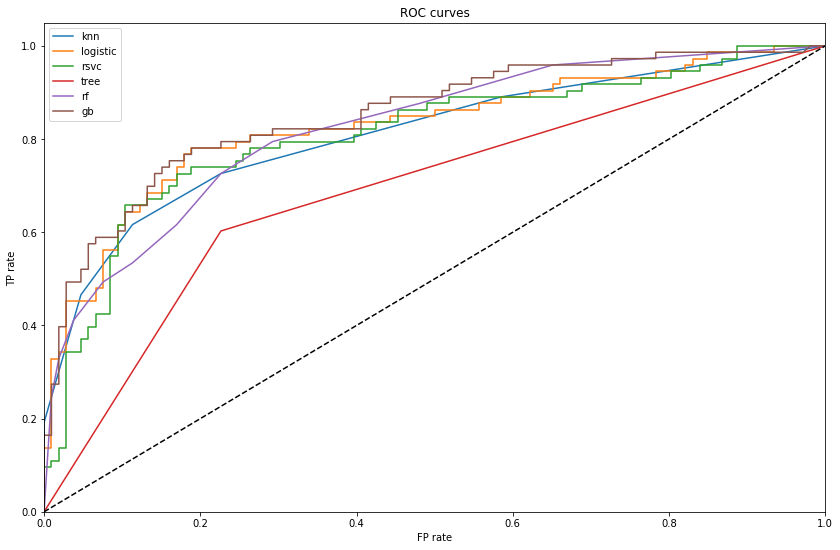

In [64]:
aml.roc_curves(pipelines=pipelines_pca)

In [65]:
aml.confusion_matrix(pipelines=pipelines_pca)

,precision,recall
gb,0.768000,0.905660
knn,0.770492,0.886792
logistic,0.810811,0.849057
rf,0.734375,0.886792
rsvc,0.796460,0.849057
tree,0.738739,0.773585


In [66]:
param_grids = {
    'knn': {'pca__n_components':[5,7,9],
                'est__n_neighbors':[3,5,7,9]},
    'logistic': {'pca__n_components':[5,7,9],
                'est__C':[0.1,1.0,10.0,100.0]},
    'rsvc': {'pca__n_components':[5,7,9],
                'est__C':[0.1,1.0,10.0,100.0],
                'est__gamma':[0.001,0.0001]},
    'lsvc': {'pca__n_components':[5,7,9],
                'est__C':[0.1,1.0,10.0,100.0]},
    'tree': {'pca__n_components':[5,7,9],
                'est__criterion': ['gini', 'entropy']},
    'rf': {'pca__n_components':[5,7,9],
               'est__criterion': ['gini', 'entropy'],
              'est__n_estimators': [10, 50, 100],
              'est__max_depth': [3,5,7]},
    'gb': {'pca__n_components':[5,7,9],
               'est__loss': ['deviance', 'exponential'],
               'est__learning_rate':[0.001, 0.01, 0.1,1.0],
               'est__n_estimators': [10, 50, 100],
               'est__max_depth': [2, 3, 5]}
}
aml.grid_searchCV(param_grid=param_grids, pipelines=pipelines_pca)


,auc_score
gb,0.827475
knn,0.818170
logistic,0.836780
rf,0.853709
rsvc,0.831739
tree,0.691199


In [67]:
param_distributions = {
    'knn':{'pca__n_components':[i for i in range(5,10)],
                'est__n_neighbors':[i for i in range(3,10)]},
    'logistic': {'pca__n_components':[i for i in range(5,10)],
                'est__C':[10**i for i in range(-1, 3)]},
    'rsvc': {'pca__n_components':[i for i in range(5,10)],
                'est__C':[10**i for i in range(-1, 3)],
                'est__gamma':[10**i for i in range(-5, -2)]},
    'lsvc': {'pca__n_components':[i for i in range(5,10)],
                'est__C':[10**i for i in range(-1, 3)]},
    'tree': {'pca__n_components':[i for i in range(5,10)],
                'est__criterion': ['gini', 'entropy']},
    'rf': {'pca__n_components':[i for i in range(5,10)],
               'est__criterion': ['gini', 'entropy'],
              'est__n_estimators': [i for i in range(10,100)],
              'est__max_depth': [i for i in range(3,10)]},
    'gb': {'pca__n_components':[i for i in range(5,10)],
               'est__loss': ['deviance', 'exponential'],
               'est__learning_rate':[10**i for i in range(-3, 1)],
               'est__n_estimators': [i for i in range(10,100)],
               'est__max_depth': [i for i in range(2,6)]}
}
aml.random_searchCV(param_distributions=param_distributions, pipelines=pipelines_pca)

,auc_score
gb,0.857198
knn,0.818170
logistic,0.837813
rf,0.854484
rsvc,0.831739
tree,0.668067
